# ViT for Multi-label Image Classification with fastai

In [26]:
from fastai.vision.all import *
from torchvision.models import resnet34

## Data loading

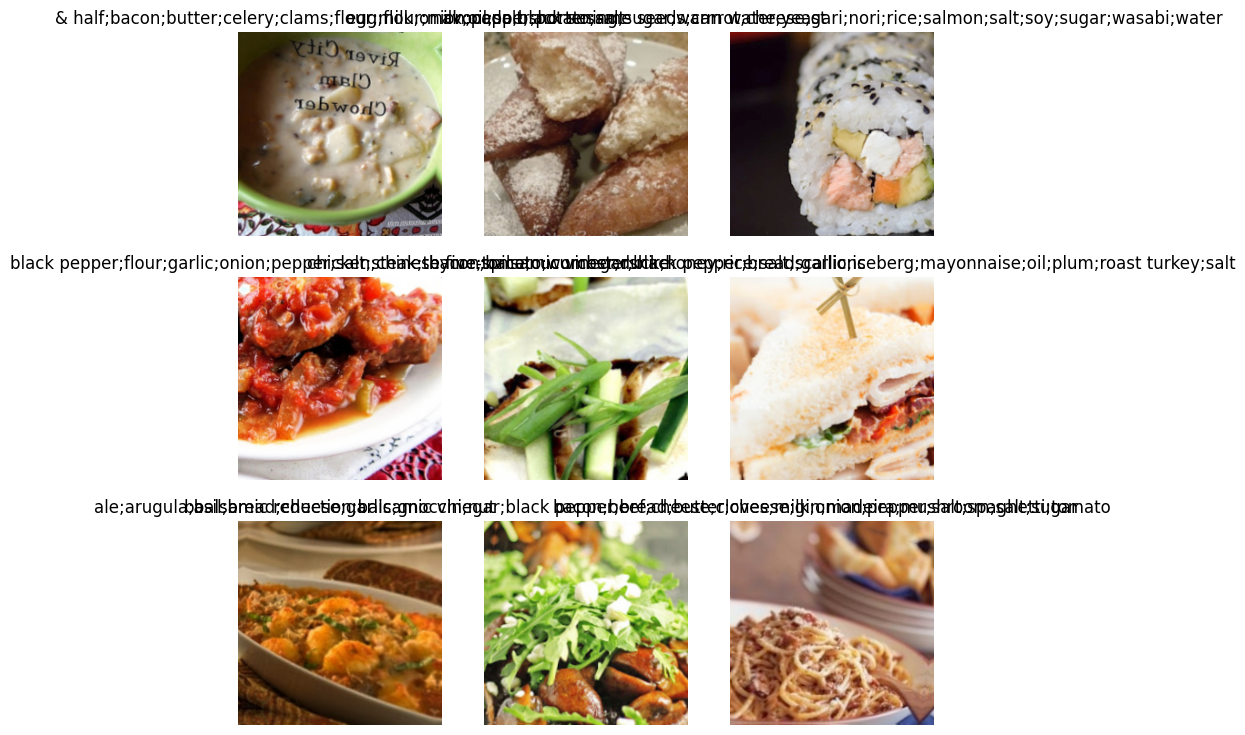

In [27]:
import pandas as pd
from fastai.vision.all import *
from pathlib import Path

# Define paths to your dataset
annotations_path = Path('../data/Recipes5k/annotations/')
images_path = Path('../data/Recipes5k/images/')

# Function to read data from text files
def read_data(images_file, labels_file, ingredients_file):
    with open(annotations_path/images_file, 'r') as f:
        images = f.read().strip().split('\n')
    with open(annotations_path/labels_file, 'r') as f:
        index = f.read().strip().split('\n')
    with open(annotations_path/ingredients_file, 'r') as f:
        labels = f.read().strip().split('\n')

    # map the indez to the ingredients list (labels)
    ingredients = [labels[int(i)] for i in index]
    
    return pd.DataFrame({'image': images, 'ingredients': ingredients, 'index': index})

# Load training, validation, and test data
train_df = read_data('train_images.txt', 'train_labels.txt', 'ingredients_simplified_Recipes5k.txt')
test_df = read_data('test_images.txt', 'test_labels.txt', 'ingredients_simplified_Recipes5k.txt')
valid_df = read_data('val_images.txt', 'val_labels.txt', 'ingredients_simplified_Recipes5k.txt')

# Create a DataBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Alternatively, use IndexSplitter for your validation set
                   get_x=lambda x: images_path/x['image'],  # Adjust path as necessary
                   get_y=lambda x: x['ingredients'].split(','),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(size=224))

# Create a DataLoaders object
dls = dblock.dataloaders(train_df, bs=32)

# Check if everything is loaded correctly
dls.show_batch()

In [28]:
train_df.tail()


,image,ingredients,index
3404,chocolate_ice_cream/12_caramelized_white_chocolate_ice_cream_hostedLargeUrl.jpg,"chocolate,milk,sugar,salt,egg",4788
3405,chocolate_ice_cream/32_chocolate_ice_cream_hostedLargeUrl.jpg,"chocolate,chocolate,whipping,milk,cheese,sugar,cocoa,vanilla",4808
3406,chocolate_ice_cream/8_milkiest_chocolate_ice_cream_hostedLargeUrl.jpg,"milk,corn starch,chocolate,milk,sugar,corn syrup,cocoa,salt",4784
3407,chocolate_ice_cream/7_chocolate_ice_cream_hostedLargeUrl.jpg,"whipping,milk,egg,sugar,cocoa,vanilla,chocolate,ice",4783
3408,chocolate_ice_cream/19_chocolate_ice_cream_hostedLargeUrl.jpg,"condensed milk,chocolate,whipping,cocoa,vanilla",4795


## Tensorboard Integration

In [29]:
from fastai.callback.all import Callback
from torch.utils.tensorboard import SummaryWriter
import os

class TensorBoardCallback(Callback):
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.writer = None

    def before_fit(self):
        """ Set up the SummaryWriter before fitting the model """
        path = os.path.join(self.log_dir, 'runs')  # You might want to customize the path
        self.writer = SummaryWriter(path)

    def after_batch(self):
        """ Log loss and other metrics after each batch """
        if self.training:
            self.writer.add_scalar('Loss/Train', self.loss.item(), self.train_iter)

    def after_epoch(self):
        """ Log validation metrics after each epoch """
        for name, value in zip(self.learn.recorder.metric_names[1:-1], self.learn.recorder.log[1:-1]):
            self.writer.add_scalar(f'{name}/Epoch', value, self.epoch)

    def after_fit(self):
        """ Close the writer after fitting """
        self.writer.close()


## Model Training

In [30]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import create_cnn_model
from fastai.vision.all import *
import timm
from torch import nn

def create_vit_model(num_classes):
    # Load a pre-trained Vision Transformer model without the classification head
    model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=0)

    # Number of features from the transformer blocks
    n_features = model.num_features

    # Replace the classifier head with a new one suited to the number of output classes
    model.head = nn.Sequential(
        nn.Linear(n_features, 512),  # Dimension reduction
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),  # Ensure this matches your dataset's number of classes
        nn.Sigmoid()  # Use Sigmoid for multi-label classification
    )
    return model

# Specify the number of classes based on your dataset labels
num_classes = len(dls.vocab)  # Set this to match the number of unique labels/classes
vit_model = create_vit_model(num_classes)

In [31]:
# Test Model Input-Output
x, y = dls.one_batch()
print('Input batch shape:', x.shape)
print('Output labels shape:', y.shape)

# Create Learner
learn = Learner(dls, vit_model, metrics=partial(accuracy_multi, thresh=0.2))

# Preview what the model outputs with one batch
print('Model output shape:', learn.model(x).shape)

Input batch shape: torch.Size([32, 3, 224, 224])
Output labels shape: torch.Size([32, 839])
Model output shape: torch.Size([32, 839])


In [32]:
from fastai.vision.all import *

# Assume 'dls' and 'vit_model' are already defined from your model setup
learn = Learner(dls, vit_model, metrics=partial(accuracy_multi, thresh=0.2), cbs=TensorBoardCallback(log_dir='runs'))
learn.fine_tune(4, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
